#Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import scipy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Loading and cleaning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/all-data.csv',
                 encoding='unicode_escape',
                 names=['Sentiment', 'Text'])
print(df.shape)
df.head()

(4846, 2)


,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [ ]:
sum(df.duplicated(subset='Text'))

8

In [ ]:
df.drop_duplicates(subset=['Text'],keep='first',inplace=True)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4838 non-null   object
 1   Text       4838 non-null   object
dtypes: object(2)
memory usage: 75.7+ KB


#Data Visualization

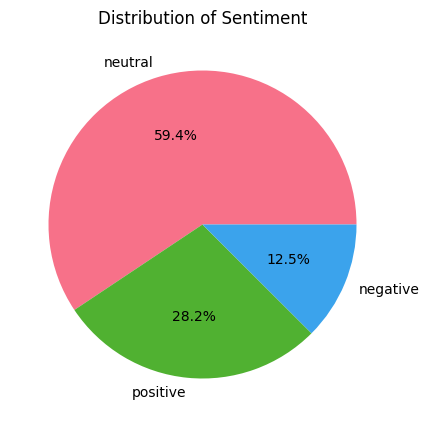

In [ ]:
sentiment_counts = df['Sentiment'].value_counts()
labels = sentiment_counts.index.to_list()
colors = sns.color_palette('husl', len(labels))
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=labels, colors=colors, autopct='%.1f%%')
plt.title('Distribution of Sentiment')
plt.show()


In [ ]:
def wordcount_gen(df, category):

    combined_tweets = " ".join([tweet for tweet in df[df.Sentiment == category]['Text']])

    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    plt.figure(figsize=(7,7))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words\n'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

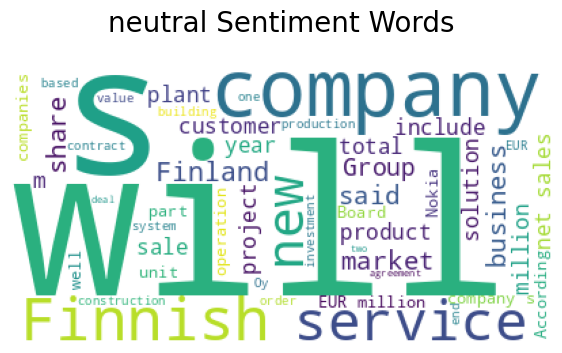

In [ ]:
wordcount_gen(df,'neutral')

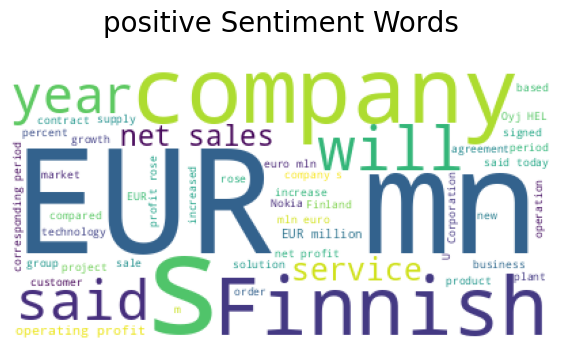

In [ ]:
wordcount_gen(df,'positive')

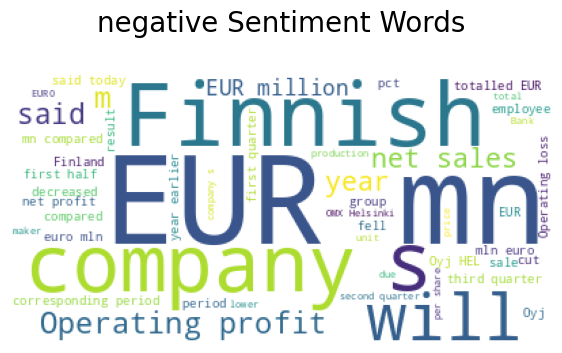

In [ ]:
wordcount_gen(df,'negative')

#First approach

##Data Preprocessing

###Tokenization

In [ ]:
#nltk.download('punkt')
texts = df['Text'].tolist()
tokenized_texts = [word_tokenize(text) for text in texts]
df['lowercase_tokenized_texts'] = [[token.lower() for token in tokens] for tokens in tokenized_texts]
df.head()

,Sentiment,Text,lowercase_tokenized_texts
0,neutral,"According to Gran , the company has no plans t...","[according, to, gran, ,, the, company, has, no..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ..."
2,negative,The international electronic industry company ...,"[the, international, electronic, industry, com..."
3,positive,With the new production plant the company woul...,"[with, the, new, production, plant, the, compa..."
4,positive,According to the company 's updated strategy f...,"[according, to, the, company, 's, updated, str..."


###Stop Words Removal

In [ ]:
#nltk.download('stopwords')
import re
def remove_punctuation(tokens):
    return [re.sub(r'[^\w\s]', '', token) for token in tokens]

# Load English stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Apply preprocessing steps
df['filtered_texts'] = df['lowercase_tokenized_texts'].apply(remove_punctuation).apply(lambda tokens: [token for token in tokens if token not in stop_words])
df= df[df['filtered_texts'].apply(lambda x: len(x) > 1)]
df = df.reset_index(drop=True)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Sentiment,Text,lowercase_tokenized_texts,filtered_texts
0,neutral,"According to Gran , the company has no plans t...","[according, to, gran, ,, the, company, has, no...","[according, gran, , company, plans, move, prod..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...","[technopolis, plans, develop, stages, area, le..."
2,negative,The international electronic industry company ...,"[the, international, electronic, industry, com...","[international, electronic, industry, company,..."
3,positive,With the new production plant the company woul...,"[with, the, new, production, plant, the, compa...","[new, production, plant, company, would, incre..."
4,positive,According to the company 's updated strategy f...,"[according, to, the, company, 's, updated, str...","[according, company, updated, strategy, years,..."


###Stemming and lemmatizing

In [ ]:
#nltk.download('wordnet')
stemmer = PorterStemmer()
lemmatizer=WordNetLemmatizer()
def join_tokens(tokens):
    return ' '.join(tokens)

df['stemmed_texts'] = df['filtered_texts'].apply(lambda tokens: [stemmer.stem(token) for token in tokens if token not in stop_words])
df['stemmed_texts'] = df['stemmed_texts'].apply(join_tokens)
df['lemmatized_texts']=df['filtered_texts'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
df['lemmatized_texts'] = df['lemmatized_texts'].apply(join_tokens)
df.head()

,Sentiment,Text,lowercase_tokenized_texts,filtered_texts,stemmed_texts,lemmatized_texts
0,neutral,"According to Gran , the company has no plans t...","[according, to, gran, ,, the, company, has, no...","[according, gran, , company, plans, move, prod...",accord gran compani plan move product russia ...,according gran company plan move production r...
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...","[technopolis, plans, develop, stages, area, le...",technopoli plan develop stage area less 100000...,technopolis plan develop stage area le 100000 ...
2,negative,The international electronic industry company ...,"[the, international, electronic, industry, com...","[international, electronic, industry, company,...",intern electron industri compani elcoteq laid ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,"[with, the, new, production, plant, the, compa...","[new, production, plant, company, would, incre...",new product plant compani would increas capac ...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,"[according, to, the, company, 's, updated, str...","[according, company, updated, strategy, years,...",accord compani updat strategi year 20092012 b...,according company updated strategy year 200920...


###Vectorizing(BOW-TFIDF)

In [ ]:
bow_vectorizer = CountVectorizer(max_features=4000, ngram_range=(1,2), max_df=0.9, min_df=0)
tfidf_vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(1,2), max_df=0.9, min_df=0)
#BOW Vectorizer
bow_matrix_s = bow_vectorizer.fit_transform(df['stemmed_texts']).todense()
bow_matrix_l = bow_vectorizer.fit_transform(df['lemmatized_texts']).todense()
#TF-IDF Vectorizer
tfidf_matrix_s = tfidf_vectorizer.fit_transform(df['stemmed_texts']).todense()
tfidf_matrix_l = tfidf_vectorizer.fit_transform(df['lemmatized_texts']).todense()
print(bow_matrix_s.shape,tfidf_matrix_s.shape)

(4837, 4000) (4837, 4000)


##Splitting data and Models training and testing

##BOW_MATRIX on stemmed text

In [ ]:
y=df['Sentiment']
# Splitting the data into training and testing sets while ensuring balanced classes
X_train, X_test, y_train, y_test = train_test_split(bow_matrix_s, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3869, 4000) (968, 4000) (3869,) (968,)


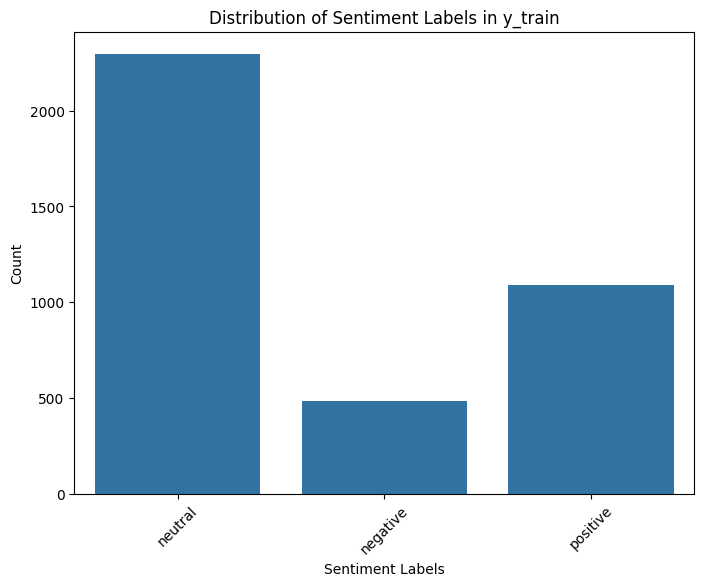

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Distribution of Sentiment Labels in y_train')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
Accuracies_1=[]
#Naive bays
nb_clf = MultinomialNB()
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_1.append(accuracy_score(y_test,y_pred)*100)
#Logistic reg
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_1.append(accuracy_score(y_test,y_pred)*100)
#svm
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_1.append(accuracy_score(y_test,y_pred)*100)
print(Accuracies_1)

              precision    recall  f1-score   support

    negative       0.54      0.60      0.57       121
     neutral       0.76      0.84      0.80       574
    positive       0.64      0.48      0.55       273

    accuracy                           0.71       968
   macro avg       0.65      0.64      0.64       968
weighted avg       0.70      0.71      0.70       968

              precision    recall  f1-score   support

    negative       0.75      0.52      0.61       121
     neutral       0.77      0.88      0.82       574
    positive       0.69      0.58      0.63       273

    accuracy                           0.75       968
   macro avg       0.74      0.66      0.69       968
weighted avg       0.74      0.75      0.74       968

              precision    recall  f1-score   support

    negative       0.81      0.29      0.43       121
     neutral       0.72      0.97      0.82       574
    positive       0.75      0.41      0.53       273

    accuracy        

## Analysis:

### Precision, Recall, and F1-score:
- Model 2 performs the best overall, with higher precision, recall, and F1-scores for all sentiment classes compared to Models 1 and 3.
- Model 1 has decent precision and recall for Neutral sentiment but lower performance for Negative and Positive sentiments.
- Model 3 has high precision for Negative sentiment but low recall, indicating that it may be biased towards predicting Negative sentiment when it's not actually the case.

### Accuracy:
- Model 2 has the highest accuracy at 74.79%, followed by Model 1 at 71.06% and Model 3 at 72.52%.
- However, accuracy alone may not provide a complete picture, especially for unbalanced datasets where the majority class dominates.

### Macro and Weighted Averages:
- The macro-average F1-score (averaging F1-scores across all classes) and weighted average F1-score (weighted by class support) are highest for Model 2, indicating better overall performance.

In summary, Model 2 seems to be the most balanced and effective among the three models based on the provided performance metrics. However, further analysis like confusion matrices and consideration of business objectives could provide additional insights into model selection.


##BOW_MATRIX of lemmatized

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_matrix_l, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3869, 4000) (968, 4000) (3869,) (968,)


In [ ]:
Accuracies_2=[]
#Naive bays
nb_clf = MultinomialNB()
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_2.append(accuracy_score(y_test,y_pred)*100)
#Logistic reg
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_2.append(accuracy_score(y_test,y_pred)*100)
#svm
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_2.append(accuracy_score(y_test,y_pred)*100)
print(Accuracies_2)

              precision    recall  f1-score   support

    negative       0.57      0.59      0.58       121
     neutral       0.76      0.84      0.79       574
    positive       0.63      0.48      0.54       273

    accuracy                           0.70       968
   macro avg       0.65      0.63      0.64       968
weighted avg       0.70      0.70      0.70       968



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.71      0.50      0.59       121
     neutral       0.76      0.87      0.81       574
    positive       0.69      0.57      0.62       273

    accuracy                           0.74       968
   macro avg       0.72      0.65      0.68       968
weighted avg       0.74      0.74      0.73       968

              precision    recall  f1-score   support

    negative       0.84      0.26      0.39       121
     neutral       0.71      0.97      0.82       574
    positive       0.73      0.38      0.50       273

    accuracy                           0.71       968
   macro avg       0.76      0.53      0.57       968
weighted avg       0.73      0.71      0.67       968

[70.45454545454545, 74.17355371900827, 71.38429752066115]


## Analysis:

### Precision, Recall, and F1-score:
- Model 2 performs the best overall, with higher precision, recall, and F1-scores for all sentiment classes compared to Models 1 and 3.
- Model 1 has decent precision and recall for Neutral sentiment but lower performance for Negative and Positive sentiments.
- Model 3 has high precision for Negative sentiment but low recall, indicating that it may be biased towards predicting Negative sentiment when it's not actually the case.

### Accuracy:
- Model 2 has the highest accuracy at 74.17%, followed by Model 1 at 70.45% and Model 3 at 71.38%.
- However, note the ConvergenceWarning for Model 1, suggesting potential issues with convergence that need to be addressed.

### Macro and Weighted Averages:
- The macro-average F1-score (averaging F1-scores across all classes) and weighted average F1-score (weighted by class support) are highest for Model 2, indicating better overall performance.

In summary, Model 2 seems to be the most balanced and effective among the three models based on the provided performance metrics. However, the ConvergenceWarning for Model 1 should be investigated further, and additional analysis like confusion matrices and consideration of business objectives could provide additional insights into model selection.


##TF-IDF of stemmed

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_s, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3869, 4000) (968, 4000) (3869,) (968,)


In [ ]:
Accuracies_3=[]
#Naive bays
nb_clf = MultinomialNB()
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_3.append(accuracy_score(y_test,y_pred)*100)
#Logistic reg
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_3.append(accuracy_score(y_test,y_pred)*100)
#svm
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_3.append(accuracy_score(y_test,y_pred)*100)
print(Accuracies_3)

              precision    recall  f1-score   support

    negative       0.85      0.24      0.37       121
     neutral       0.70      0.96      0.81       574
    positive       0.65      0.36      0.47       273

    accuracy                           0.70       968
   macro avg       0.74      0.52      0.55       968
weighted avg       0.71      0.70      0.66       968

              precision    recall  f1-score   support

    negative       0.82      0.39      0.53       121
     neutral       0.74      0.95      0.83       574
    positive       0.77      0.49      0.60       273

    accuracy                           0.75       968
   macro avg       0.78      0.61      0.65       968
weighted avg       0.76      0.75      0.73       968

              precision    recall  f1-score   support

    negative       0.86      0.36      0.51       121
     neutral       0.72      0.97      0.83       574
    positive       0.79      0.42      0.55       273

    accuracy        

##TF-IDF lemmatized

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_l, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3869, 4000) (968, 4000) (3869,) (968,)


In [ ]:
Accuracies_4=[]
#Naive bays
nb_clf = MultinomialNB()
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_4.append(accuracy_score(y_test,y_pred)*100)
#Logistic reg
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_4.append(accuracy_score(y_test,y_pred)*100)
#svm
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracies_4.append(accuracy_score(y_test,y_pred)*100)
print(Accuracies_4)

              precision    recall  f1-score   support

    negative       0.86      0.25      0.38       121
     neutral       0.70      0.95      0.81       574
    positive       0.66      0.37      0.47       273

    accuracy                           0.70       968
   macro avg       0.74      0.52      0.56       968
weighted avg       0.71      0.70      0.66       968

              precision    recall  f1-score   support

    negative       0.81      0.35      0.49       121
     neutral       0.72      0.94      0.82       574
    positive       0.70      0.44      0.54       273

    accuracy                           0.72       968
   macro avg       0.74      0.58      0.61       968
weighted avg       0.73      0.72      0.70       968

              precision    recall  f1-score   support

    negative       0.86      0.36      0.51       121
     neutral       0.71      0.96      0.82       574
    positive       0.77      0.40      0.53       273

    accuracy        

Model 3 is the best

##Conclusion

In [ ]:
Results = Accuracies_1 + Accuracies_2 + Accuracies_3 + Accuracies_4
print(Results)
#Highest result was for Logistic Regression model in the Stemmed TF-IDF showing also very good PRECISION-RECALL-F1 score from the last models

[70.55785123966942, 74.79338842975206, 72.52066115702479, 70.45454545454545, 74.17355371900827, 71.38429752066115, 69.93801652892562, 74.89669421487604, 73.86363636363636, 70.14462809917356, 72.41735537190083, 72.93388429752066]


#Second approach

###Using Vader

In [ ]:
#nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I love cookie')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [ ]:
sia.polarity_scores('I love cookies!!')

{'neg': 0.0, 'neu': 0.173, 'pos': 0.827, 'compound': 0.6988}

In [ ]:
sia.polarity_scores(df['Text'][4843])

{'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'compound': 0.743}

In [ ]:
sia.polarity_scores(df['Text'][1])

{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'compound': -0.296}

In [ ]:
predicted_sentiments = []
for text in df['Text']:
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        predicted_sentiments.append('positive')
    elif score['compound'] <= -0.05:
        predicted_sentiments.append('negative')
    else:
        predicted_sentiments.append('neutral')

df['predicted_sia'] = predicted_sentiments

In [ ]:
df

,Sentiment,Text,predicted_sia
0,neutral,"According to Gran , the company has no plans t...",negative
1,neutral,Technopolis plans to develop in stages an area...,negative
2,negative,The international electronic industry company ...,neutral
3,positive,With the new production plant the company woul...,positive
4,positive,According to the company 's updated strategy f...,positive
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive
4844,negative,Net sales of the Paper segment decreased to EU...,positive


In [ ]:
y=df['Sentiment'].to_list()
print(f'Accuracy-Score: {accuracy_score(y, predicted_sentiments)}')

Accuracy-Score: 0.5431996692848284


###Using Finbert

In [ ]:
X = df['Text'].to_list()
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_finbert(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model_finbert.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [ ]:
df['predicted_finbert'] = preds
df

,Sentiment,Text,predicted_sia,predicted_finbert
0,neutral,"According to Gran , the company has no plans t...",negative,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral
2,negative,The international electronic industry company ...,neutral,negative
3,positive,With the new production plant the company woul...,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive
...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative


In [ ]:
y=df['Sentiment'].to_list()
print(f'Accuracy-Score: {accuracy_score(y, preds)}')

Accuracy-Score: 0.8892104175279041


###Using Twitter-Roberta

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
preds_roberta = []
preds_proba_roberta = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_roberta(**input_sequence).logits
        scores = scipy.special.softmax(logits.numpy().squeeze())
        labels = ['negative', 'neutral', 'positive']
        scores_dict = {label: score for label, score in zip(labels, scores)}
        sentimentRoberta = max(scores_dict, key=scores_dict.get)
        probabilityRoberta = max(scores_dict.values())
        preds_roberta.append(sentimentRoberta)
        preds_proba_roberta.append(probabilityRoberta)

In [ ]:
df['predicted_roberta'] = preds_roberta

In [ ]:
df

,Sentiment,Text,predicted_sia,predicted_finbert,predicted_roberta
0,neutral,"According to Gran , the company has no plans t...",negative,neutral,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral,neutral
2,negative,The international electronic industry company ...,neutral,negative,negative
3,positive,With the new production plant the company woul...,positive,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive,neutral
...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative,neutral
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative,neutral


In [ ]:
y=df['Sentiment'].to_list()
print(f'Accuracy-Score: {accuracy_score(y, preds_roberta)}')

Accuracy-Score: 0.666391070690368


###Using Finbert-Tone

In [ ]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

results = df['Text'].apply(lambda x: nlp(x)[0])

df['predicted_finbertTone'] = results.apply(lambda x: x['label'].lower())

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
df

,Sentiment,Text,predicted_sia,predicted_finbert,predicted_roberta,predicted_finbertTone
0,neutral,"According to Gran , the company has no plans t...",negative,neutral,neutral,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral,neutral,neutral
2,negative,The international electronic industry company ...,neutral,negative,negative,neutral
3,positive,With the new production plant the company woul...,positive,positive,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive,neutral,positive
...,...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative,neutral,positive
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative,neutral,negative
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative,neutral,negative


In [ ]:
y=df['Sentiment'].to_list()
preds_finberttone=df['predicted_finbertTone'].to_list()
print(f'Accuracy-Score: {accuracy_score(y, preds_finberttone)}')

Accuracy-Score: 0.7924762298470442


##Evaluation

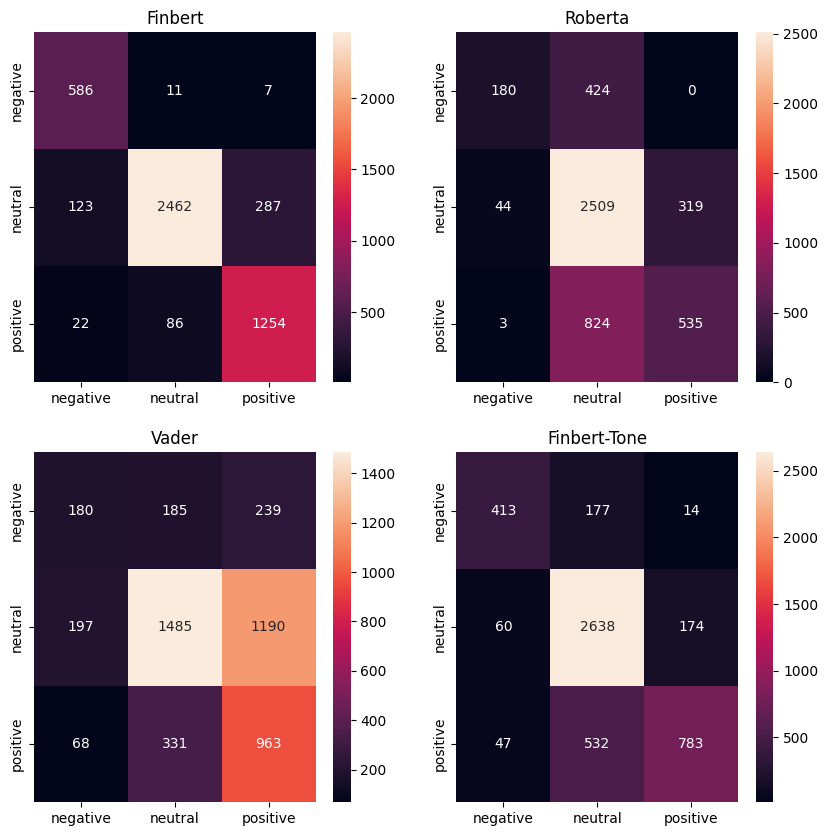

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
labels = ['negative', 'neutral', 'positive']
sns.heatmap(confusion_matrix(y, preds), annot=True, fmt='g', ax=axes[0, 0], xticklabels=labels, yticklabels=labels)
axes[0, 0].set_title('Finbert')
sns.heatmap(confusion_matrix(y, preds_roberta), annot=True, fmt='g', ax=axes[0, 1], xticklabels=labels, yticklabels=labels)
axes[0, 1].set_title('Roberta')
sns.heatmap(confusion_matrix(y, predicted_sentiments), annot=True, fmt='g', ax=axes[1, 0], xticklabels=labels, yticklabels=labels)
axes[1, 0].set_title('Vader')
sns.heatmap(confusion_matrix(y, preds_finberttone), annot=True, fmt='g', ax=axes[1, 1], xticklabels=labels, yticklabels=labels)
axes[1, 1].set_title('Finbert-Tone')
plt.show()


In [ ]:
print(classification_report(y,preds))

              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2872
    positive       0.81      0.92      0.86      1362

    accuracy                           0.89      4838
   macro avg       0.86      0.92      0.88      4838
weighted avg       0.90      0.89      0.89      4838

